In [1]:
# File processing
import glob
import os

# Data processing
import random
import numpy as np
from tqdm import tqdm

# Data display 
import matplotlib
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from matplotlib.legend_handler import HandlerLine2D

# Machine learning
import torch
import torch.nn.functional as F
from torch import linalg as LAtorch
from numpy import linalg as LAnumpy
from torch_geometric.data import DataLoader
from sklearn.preprocessing import MinMaxScaler
from torch_geometric.data import Data, InMemoryDataset

# Setting device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
NB_EPOCHS = 89
#####100
BATCH_SIZE = 10
NB_BINS = 202
EMBEDDING_SIZE = 3 # Euclidean 3D space
LEARNING_RATE = 0.001
SEED = 0
LAMBDA_BIOLOGICAL = 0
LAMBDA_KABSCH = 0.1
TRAIN_DATASET_SIZE = 800
TEST_DATASET_SIZE = 200

# Trussart analysis dataset constants
TRUSSART_HIC_PATH = '../../../../data/trussart/hic_matrices/150_TADlike_alpha_150_set0.mat'
TRUSSART_STRUCTURES_PATH = '../../../../data/trussart/structure_matrices/'

In [3]:
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

In [4]:
trussart_hic = np.loadtxt(TRUSSART_HIC_PATH, dtype='f', delimiter='\t')
scaler = MinMaxScaler()
trussart_hic = scaler.fit_transform(trussart_hic)

In [5]:
trussart_structures = []

file_list = os.listdir(TRUSSART_STRUCTURES_PATH)
file_list = filter(lambda f: f.endswith('.xyz'), file_list)

for file_name in file_list:
    current_trussart_structure = np.loadtxt(TRUSSART_STRUCTURES_PATH + file_name, dtype='f', delimiter='\t')
    current_trussart_structure = current_trussart_structure[:,1:]
    trussart_structures.append(current_trussart_structure)

In [6]:
# grab last 4 digits of the file txt name:
def last_4digits(x):
    return(x[-8:-4])

In [7]:
train_transfer_learning_hics = []

file_list = os.listdir('../data/synthetic_random/train/hic_matrices/')

for file_name in sorted(filter(lambda x: x.endswith('.txt'), file_list), key = last_4digits):
    current_train_transfer_learning_hic = np.loadtxt('../data/synthetic_random/train/hic_matrices/'\
                                                     + file_name, dtype='f', delimiter=' ')
    train_transfer_learning_hics.append(current_train_transfer_learning_hic)

In [8]:
test_transfer_learning_hics = []

file_list = os.listdir('../data/synthetic_random/test/hic_matrices/')

for file_name in sorted(filter(lambda x: x.endswith('.txt'), file_list), key = last_4digits):
    current_test_transfer_learning_hic = np.loadtxt('../data/synthetic_random/test/hic_matrices/'\
                                                     + file_name, dtype='f', delimiter=' ')
    test_transfer_learning_hics.append(current_test_transfer_learning_hic)

In [9]:
train_transfer_learning_structures = []

file_list = os.listdir('../data/synthetic_random/train/structure_matrices/')

for file_name in sorted(filter(lambda x: x.endswith('.txt'), file_list), key = last_4digits):
    current_train_transfer_learning_structure = \
        np.loadtxt('../data/synthetic_random/train/structure_matrices/'\
                                                     + file_name, dtype='f', delimiter=' ')
    train_transfer_learning_structures.append(current_train_transfer_learning_structure)

In [10]:
test_transfer_learning_structures = []

file_list = os.listdir('../data/synthetic_random/test/structure_matrices/')

for file_name in sorted(filter(lambda x: x.endswith('.txt'), file_list), key = last_4digits):
    current_test_transfer_learning_structure = \
        np.loadtxt('../data/synthetic_random/test/structure_matrices/'\
                                                     + file_name, dtype='f', delimiter=' ')
    test_transfer_learning_structures.append(current_test_transfer_learning_structure)

In [11]:
train_transfer_learning_distances = []

file_list = os.listdir('../data/synthetic_random/train/distance_matrices/')

for file_name in sorted(filter(lambda x: x.endswith('.txt'), file_list), key = last_4digits):
    current_train_transfer_learning_distance = \
            np.loadtxt('../data/synthetic_random/train/distance_matrices/'\
                                                     + file_name, dtype='f', delimiter=' ')
    train_transfer_learning_distances.append(current_train_transfer_learning_distance)

In [12]:
test_transfer_learning_distances = []

file_list = os.listdir('../data/synthetic_random/test/distance_matrices/')

for file_name in sorted(filter(lambda x: x.endswith('.txt'), file_list), key = last_4digits):
    current_test_transfer_learning_distance = \
            np.loadtxt('../data/synthetic_random/test/distance_matrices/'\
                                                     + file_name, dtype='f', delimiter=' ')
    test_transfer_learning_distances.append(current_test_transfer_learning_distance)

In [13]:
is_training = True

In [14]:
class VanillaDataset(InMemoryDataset):
    def __init__(self, root, transform=None, pre_transform=None):
        super(VanillaDataset, self).__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        return []
    @property
    def processed_file_names(self):
        if is_training:
            return ['synthetic_biological_trussart_linear_train_data.txt']
        else:
            return ['synthetic_biological_trussart_linear_test_data.txt']

    def download(self):
        pass
        
    def process(self):
        
        data_list = []
        if is_training:
            dataset_size = TRAIN_DATASET_SIZE
        else:
            dataset_size = TEST_DATASET_SIZE
        
        for i in tqdm(range(dataset_size)):
            
            if is_training:
                transfer_learning_hic = train_transfer_learning_hics[i]
                transfer_learning_structure = train_transfer_learning_structures[i]
                transfer_learning_distance_matrix = train_transfer_learning_distances[i]
            else:
                transfer_learning_hic = test_transfer_learning_hics[i]
                transfer_learning_structure = test_transfer_learning_structures[i]
                transfer_learning_distance_matrix = test_transfer_learning_distances[i]
               
            hic_matrix = torch.FloatTensor(transfer_learning_hic)
            structure_matrix = torch.FloatTensor(transfer_learning_structure)
            distance_matrix = torch.FloatTensor(transfer_learning_distance_matrix)

            data = Data(hic_matrix=hic_matrix, structure_matrix=structure_matrix, distance_matrix=distance_matrix)
            data_list.append(data)
            
        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_paths[0])

In [15]:
train_dataset = VanillaDataset('../')
train_dataset = train_dataset.shuffle()

In [16]:
train_size = len(train_dataset)
train_size

800

In [17]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE)

In [18]:
is_training = False

In [19]:
test_dataset = VanillaDataset('../')
test_dataset = test_dataset.shuffle()

In [20]:
test_size = len(test_dataset)
test_size

200

In [21]:
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [22]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.linear_encoder_layer_1 = torch.nn.Linear(NB_BINS, 100)
        self.linear_encoder_layer_2 = torch.nn.Linear(100, 50)
        self.linear_encoder_layer_3 = torch.nn.Linear(50, EMBEDDING_SIZE)
        
    def forward(self, x, is_training=False):
        
        x = torch.reshape(x, (BATCH_SIZE, NB_BINS, NB_BINS))
        
        z = self.linear_encoder_layer_1(x)
        z = F.relu(z)
        z = self.linear_encoder_layer_2(z)
        z = F.relu(z)
        z = self.linear_encoder_layer_3(z)
        z = F.relu(z)
        z = centralize_and_normalize_torch(z)
        
        w = torch.cdist(z, z, p=2)
        
        return z, w

In [23]:
def centralize_torch(z):
    return z - torch.repeat_interleave(torch.reshape(torch.mean(z, axis=1), (-1,1,EMBEDDING_SIZE)), NB_BINS, dim=1)

In [24]:
def normalize_torch(z):
    
    norms = LAtorch.norm(z, 2, dim=2)
    max_norms, _ = torch.max(norms, axis=1)
    max_norms = torch.reshape(max_norms, (BATCH_SIZE,1,1))
    max_norms = torch.repeat_interleave(max_norms, NB_BINS, dim=1)
    max_norms = torch.repeat_interleave(max_norms, EMBEDDING_SIZE, dim=2)
    max_norms[max_norms == 0] = 1
    
    return z / max_norms

In [25]:
def centralize_and_normalize_torch(z):
    
    # Translate
    z = centralize_torch(z)
    
    # Scale
    z = normalize_torch(z)
    
    return z

In [26]:
def centralize_numpy(z):
    return z - np.mean(z, axis=0)

In [27]:
def normalize_numpy(z):
    
    norm = LAnumpy.norm(z, 2, axis=1)
    max_norm = np.max(norm, axis=0)
    if max_norm == 0:
        max_norm = 1
    
    return z / max_norm

In [28]:
def centralize_and_normalize_numpy(z):
    
    # Translate
    z = centralize_numpy(z)
    
    # Scale
    z = normalize_numpy(z)
    
    return z

In [29]:
def kabsch_superimposition_numpy(pred_structure, true_structure):
    
    # Centralize and normalize to unit ball
    pred_structure_unit_ball = centralize_and_normalize_numpy(pred_structure)
    true_structure_unit_ball = centralize_and_normalize_numpy(true_structure)
    
    # Rotation (solution for the constrained orthogonal Procrustes problem, subject to det(R) = 1)
    m = np.matmul(np.transpose(true_structure_unit_ball), pred_structure_unit_ball)
    u, s, vh = np.linalg.svd(m)
    
    d = np.sign(np.linalg.det(np.matmul(u, vh)))
    a = np.eye(EMBEDDING_SIZE)
    a[-1,-1] = d
    
    r = np.matmul(np.matmul(u, a), vh)
    
    pred_structure_unit_ball = np.transpose(np.matmul(r, np.transpose(pred_structure_unit_ball)))
    
    return pred_structure_unit_ball, true_structure_unit_ball

In [30]:
def kabsch_distance_numpy(pred_structure, true_structure):
    
    pred_structure_unit_ball, true_structure_unit_ball = \
            kabsch_superimposition_numpy(pred_structure, true_structure)
    
    # Structure comparison
    d = np.mean(np.sum(np.square(pred_structure_unit_ball - true_structure_unit_ball), axis=1))
    
    return d

In [31]:
def compute_trussart_test_kabsch_loss():
    
    torch_trussart_hic = torch.FloatTensor(trussart_hic)
    torch_trussart_hic = torch.reshape(torch_trussart_hic, (1, NB_BINS, NB_BINS))
    torch_trussart_hic = torch.repeat_interleave(torch_trussart_hic, BATCH_SIZE, 0)
    
    trussart_pred_structure, _ = model(torch_trussart_hic)
    trussart_pred_structure = trussart_pred_structure.detach().numpy()[0]
    
    kabsch_distances = []
    for true_structure in trussart_structures:
        kabsch_distances.append(kabsch_distance_numpy(trussart_pred_structure, true_structure))
        
    return np.mean(kabsch_distances)

In [32]:
def biological_loss_fct(pred_structure, true_structure, pred_distance, true_distance):
    
    ####### Pairwise distances loss ########
    
    between_bin_distance = \
        torch.diagonal(pred_distance.reshape((BATCH_SIZE, NB_BINS, NB_BINS)), offset=1, dim1=1, dim2=2)
    between_bin_distance_loss = torch.var(between_bin_distance)
    
    ######### Pairwise angles loss ##########
    
    pred_structure_vectors = (pred_structure - torch.roll(pred_structure, 1, dims=1))[:, 1:, :]
    pred_structure_dot_products = \
        torch.matmul(pred_structure_vectors, torch.transpose(pred_structure_vectors, dim0=1, dim1=2))
    pairwise_angles_loss = \
        torch.where(pred_structure_dot_products < 0, torch.ones((BATCH_SIZE, NB_BINS-1, NB_BINS-1))*0.1, \
                        torch.zeros((BATCH_SIZE, NB_BINS-1, NB_BINS-1)))
    pairwise_angles_loss = torch.mean(pairwise_angles_loss)
    
    return between_bin_distance_loss + pairwise_angles_loss

In [33]:
def kabsch_loss_fct(pred_structure, true_structure):
    
    # NOTE: the two input structures should already be centralized and normalized
    
    m = torch.matmul(torch.transpose(true_structure, 1, 2), pred_structure)
    u, s, vh = torch.linalg.svd(m)
    
    d = torch.sign(torch.linalg.det(torch.matmul(u, vh)))
    a = torch.eye(EMBEDDING_SIZE).reshape((1, EMBEDDING_SIZE, EMBEDDING_SIZE)).repeat_interleave(BATCH_SIZE, dim=0)
    a[:,-1,-1] = d
    
    r = torch.matmul(torch.matmul(u, a), vh)
    
    pred_structure = torch.transpose(torch.matmul(r, torch.transpose(pred_structure, 1, 2)), 1, 2)
    
    return torch.mean(torch.sum(torch.square(pred_structure - true_structure), axis=2))

In [34]:
distance_loss_fct = torch.nn.MSELoss()

In [35]:
device = torch.device('cpu')
model = Net().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [36]:
def plot_grad_flow(named_parameters):
    '''Plots the gradients flowing through different layers in the net during training.
    Can be used for checking for possible gradient vanishing / exploding problems.
    
    Usage: Plug this function in Trainer class after loss.backwards() as 
    "plot_grad_flow(self.model.named_parameters())" to visualize the gradient flow'''
    ave_grads = []
    max_grads= []
    layers = []
    for n, p in named_parameters:
        if(p.requires_grad) and ("bias" not in n):
            layers.append(n)
            ave_grads.append(p.grad.abs().mean())
            max_grads.append(p.grad.abs().max())
    plt.bar(np.arange(len(max_grads)), max_grads, alpha=0.1, lw=1, color="c")
    plt.bar(np.arange(len(max_grads)), ave_grads, alpha=0.1, lw=1, color="b")
    plt.hlines(0, 0, len(ave_grads)+1, lw=2, color="k" )
    plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
    plt.xlim(left=0, right=len(ave_grads))
    plt.ylim(bottom = -0.001, top=0.02) # zoom in on the lower gradient regions
    plt.xlabel("Layers")
    plt.ylabel("average gradient")
    plt.title("Gradient flow")
    plt.grid(True)
    plt.legend([matplotlib.lines.Line2D([0], [0], color="c", lw=4),
                matplotlib.lines.Line2D([0], [0], color="b", lw=4),
                matplotlib.lines.Line2D([0], [0], color="k", lw=4)], 
               ['max-gradient', 'mean-gradient', 'zero-gradient'])

In [37]:
def train():
    model.train()

    loss_all = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        
        pred_structure, pred_distance = model(data.hic_matrix)
        
        true_hic = data.hic_matrix.to(device)
        
        true_structure = data.structure_matrix.to(device)
        true_structure = torch.reshape(true_structure, (BATCH_SIZE, NB_BINS, EMBEDDING_SIZE))
        
        pred_distance = torch.reshape(pred_distance, (BATCH_SIZE*NB_BINS, NB_BINS))
        true_distance = data.distance_matrix.to(device)
        
        # Biological loss
        biological_loss = biological_loss_fct(pred_structure, true_structure, pred_distance, true_distance)
        
        # Kabsch loss
        kabsch_loss = kabsch_loss_fct(pred_structure, true_structure)
        
        # Distance loss 
        distance_loss = distance_loss_fct(pred_distance, true_distance)
        
        # Combine losses
        loss = LAMBDA_BIOLOGICAL * biological_loss + LAMBDA_KABSCH * kabsch_loss + distance_loss
        
#         with torch.autograd.detect_anomaly():
        loss.backward()
        
        loss_all += data.num_graphs * loss.item()
        
        # Plot grad flow
#         plot_grad_flow(model.named_parameters())
        
        optimizer.step()
    return loss_all / len(train_dataset)

In [38]:
def evaluate(loader):
    model.eval()

    true_hics = []
    
    pred_structures = []
    true_structures = []
    
    pred_distances = []
    true_distances = []
    
    kabsch_losses = []
    distance_losses = []
    biological_losses = []

    with torch.no_grad():
        for data in loader:

            data = data.to(device)
            
            pred_structure, pred_distance = model(data.hic_matrix)
            
            pred_structure = pred_structure.detach().cpu()
            pred_distance = pred_distance.detach().cpu()
            
            pred_distance = torch.reshape(pred_distance, (BATCH_SIZE*NB_BINS, NB_BINS))
            
            true_hic = data.hic_matrix.detach().cpu()
            true_structure = data.structure_matrix.detach().cpu()
            true_distance = data.distance_matrix.detach().cpu()
            
            true_structure = torch.reshape(true_structure, (BATCH_SIZE, NB_BINS, EMBEDDING_SIZE))
            
            # Biological loss
            biological_loss = \
                biological_loss_fct(pred_structure, true_structure, pred_distance, true_distance).numpy()
            biological_losses.append(biological_loss)
            
            # Kabsch loss
            kabsch_loss = kabsch_loss_fct(pred_structure, true_structure).numpy()
            kabsch_losses.append(kabsch_loss)
            
            # Distance loss
            distance_loss = distance_loss_fct(pred_distance, true_distance).numpy()
            distance_losses.append(distance_loss)
            
            # To numpy
            true_hic = true_hic.numpy()
            
            pred_structure = pred_structure.numpy()
            true_structure = true_structure.numpy()
            
            pred_distance = pred_distance.numpy()
            true_distance = true_distance.numpy()
            
            # Store results
            true_hics.append(true_hic)
            
            pred_structures.append(pred_structure)
            true_structures.append(true_structure)
            
            pred_distances.append(pred_distance)
            true_distances.append(true_distance)
    
    # Format results
    true_hics = np.vstack(true_hics)
    
    pred_structures = np.vstack(pred_structures)
    true_structures = np.vstack(true_structures)
    
    pred_distances = np.vstack(pred_distances)
    true_distances = np.vstack(true_distances)
    
    # Compute mean losses
    mean_biological_loss = np.mean(np.asarray(biological_loss).flatten())
    mean_kabsch_loss = np.mean(np.asarray(kabsch_losses).flatten())
    mean_distance_loss = np.mean(np.asarray(distance_losses).flatten())
    
    return mean_biological_loss, mean_kabsch_loss, mean_distance_loss, true_hics, \
            pred_structures, true_structures, pred_distances, true_distances

In [39]:
train_biological_losses_all_epochs = []
train_kabsch_losses_all_epochs = []
train_distance_losses_all_epochs = []

test_biological_losses_all_epochs = []
test_kabsch_losses_all_epochs = []
test_distance_losses_all_epochs = []

losses = []

trussart_test_kabsch_losses_all_epochs = []

for epoch in range(1, NB_EPOCHS+1):
    loss = train()
    losses.append(loss)
    
    ### Training
    train_mean_biological_loss, train_mean_kabsch_loss, train_mean_distance_loss, train_true_hics, \
        train_pred_structures, train_true_structures, train_pred_distances, \
            train_true_distances = evaluate(train_loader) 
    
    # Store results
    train_biological_losses_all_epochs.append(train_mean_biological_loss)
    train_kabsch_losses_all_epochs.append(train_mean_kabsch_loss)    
    train_distance_losses_all_epochs.append(train_mean_distance_loss)
    
    ### Testing
    test_mean_biological_loss, test_mean_kabsch_loss, test_mean_distance_loss, test_true_hics, \
        test_pred_structures, test_true_structures, test_pred_distances, \
            test_true_distances = evaluate(test_loader) 
    
    ### Trussart test
    trussart_test_kabsch_loss = compute_trussart_test_kabsch_loss()
    
    # Store results
    test_biological_losses_all_epochs.append(test_mean_biological_loss)
    test_kabsch_losses_all_epochs.append(test_mean_kabsch_loss)    
    test_distance_losses_all_epochs.append(test_mean_distance_loss)
    
    trussart_test_kabsch_losses_all_epochs.append(trussart_test_kabsch_loss)
    
    print('E: {:03d}, Tr B: {:.4f}, Tr K: {:.4f}, Tr D: {:.4f}, Te B: {:.4f}, Te K: {:.4f}, Te D: {:.4f}, Trus: {:.4f}'.format(\
        epoch, train_mean_biological_loss, train_mean_kabsch_loss, train_mean_distance_loss, \
            test_mean_biological_loss, test_mean_kabsch_loss, test_mean_distance_loss, trussart_test_kabsch_loss))

E: 001, Tr B: 0.0525, Tr K: 0.0926, Tr D: 0.0381, Te B: 0.0545, Te K: 0.0893, Te D: 0.0389, Trus: 0.0949
E: 002, Tr B: 0.0514, Tr K: 0.0787, Tr D: 0.0258, Te B: 0.0512, Te K: 0.0761, Te D: 0.0258, Trus: 0.1096
E: 003, Tr B: 0.0502, Tr K: 0.0720, Tr D: 0.0247, Te B: 0.0535, Te K: 0.0701, Te D: 0.0255, Trus: 0.0844
E: 004, Tr B: 0.0488, Tr K: 0.0623, Tr D: 0.0189, Te B: 0.0504, Te K: 0.0608, Te D: 0.0200, Trus: 0.0942
E: 005, Tr B: 0.0484, Tr K: 0.0597, Tr D: 0.0155, Te B: 0.0499, Te K: 0.0576, Te D: 0.0162, Trus: 0.0877
E: 006, Tr B: 0.0483, Tr K: 0.0600, Tr D: 0.0147, Te B: 0.0495, Te K: 0.0578, Te D: 0.0153, Trus: 0.0820
E: 007, Tr B: 0.0483, Tr K: 0.0599, Tr D: 0.0141, Te B: 0.0495, Te K: 0.0573, Te D: 0.0145, Trus: 0.0816
E: 008, Tr B: 0.0481, Tr K: 0.0578, Tr D: 0.0130, Te B: 0.0491, Te K: 0.0558, Te D: 0.0135, Trus: 0.0862
E: 009, Tr B: 0.0479, Tr K: 0.0569, Tr D: 0.0122, Te B: 0.0491, Te K: 0.0544, Te D: 0.0125, Trus: 0.0832
E: 010, Tr B: 0.0478, Tr K: 0.0556, Tr D: 0.0121, Te B:

In [40]:
np.min(trussart_test_kabsch_losses_all_epochs)

0.06424972370769395

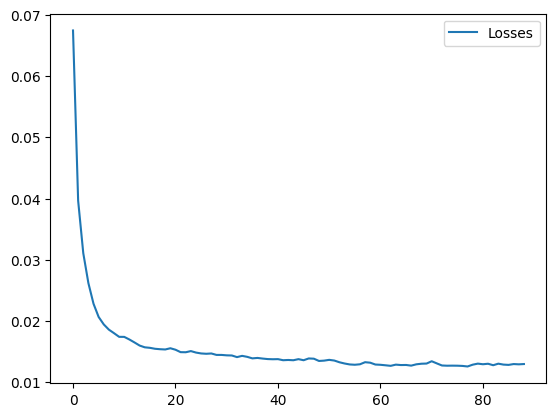

In [41]:
plt.plot(losses, label='Losses')
plt.legend()

plt.show()

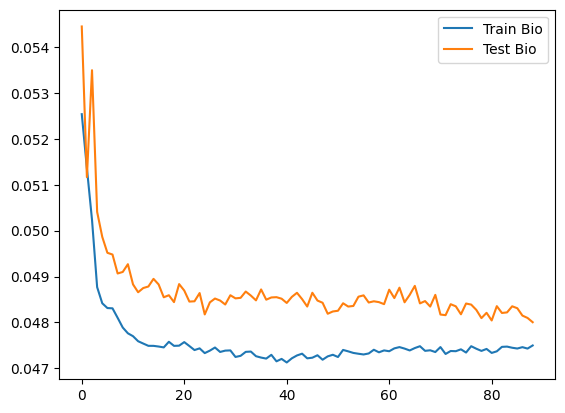

In [42]:
plt.plot(train_biological_losses_all_epochs, label='Train Bio')
plt.plot(test_biological_losses_all_epochs, label='Test Bio')

plt.legend()
plt.show()

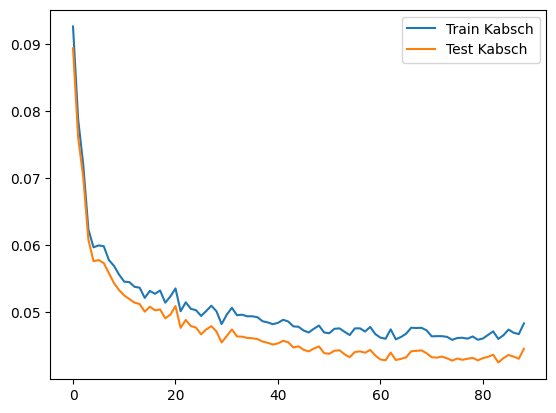

In [43]:
plt.plot(train_kabsch_losses_all_epochs, label='Train Kabsch')
plt.plot(test_kabsch_losses_all_epochs, label='Test Kabsch')

plt.legend()
plt.show()

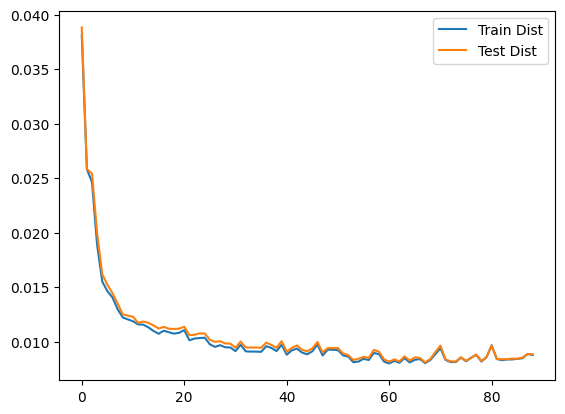

In [44]:
plt.plot(train_distance_losses_all_epochs, label='Train Dist')
plt.plot(test_distance_losses_all_epochs, label='Test Dist')

plt.legend()
plt.show()

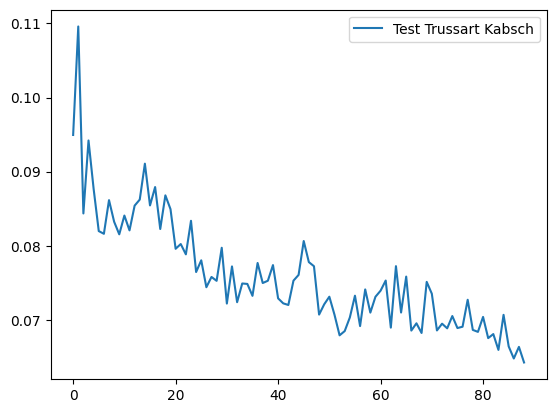

In [45]:
plt.plot(trussart_test_kabsch_losses_all_epochs, label='Test Trussart Kabsch')

plt.legend()
plt.show()

In [46]:
GRAPH_TESTED = 0

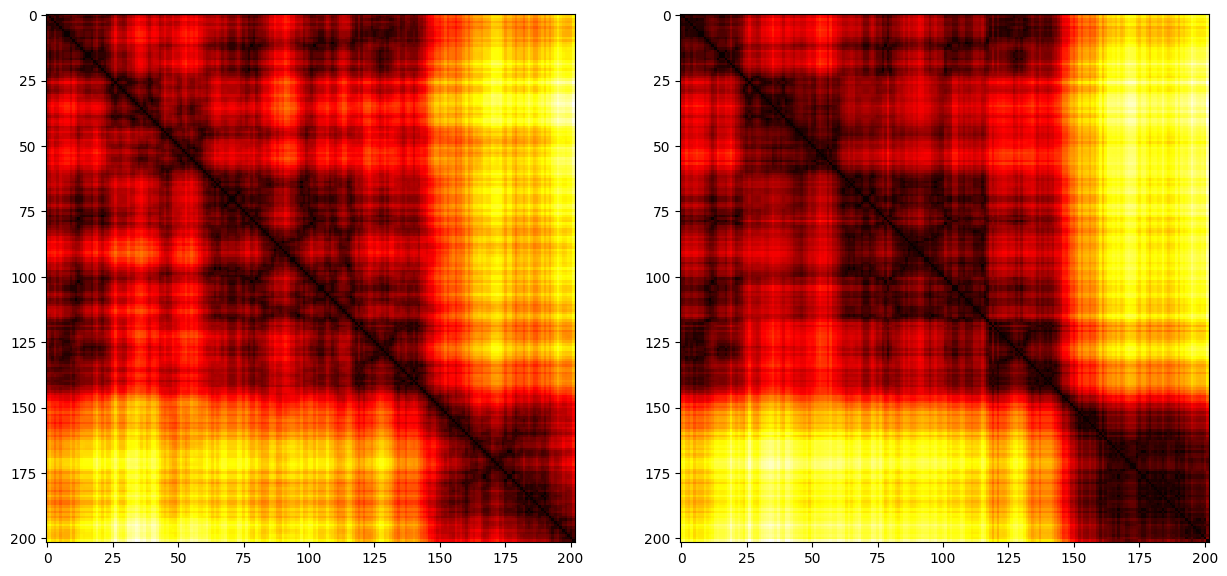

In [47]:
fig, axes = plt.subplots(1, 2, figsize=(15,15))

ground_truth_matrix = test_true_distances[GRAPH_TESTED*NB_BINS:GRAPH_TESTED*NB_BINS+NB_BINS, :]
axes[0].imshow(ground_truth_matrix, cmap='hot', interpolation='nearest')

reconstruction_matrix = test_pred_distances[GRAPH_TESTED*NB_BINS:GRAPH_TESTED*NB_BINS+NB_BINS, :]
axes[1].imshow(reconstruction_matrix, cmap='hot', interpolation='nearest')

plt.show()

In [48]:
fig = plt.figure(figsize=(50, 50))

test_true_structure = test_true_structures[GRAPH_TESTED]
test_pred_structure = test_pred_structures[GRAPH_TESTED]

test_pred_structure_superposed, test_true_structure_superposed = \
        kabsch_superimposition_numpy(test_pred_structure, test_true_structure)

x_pred = test_pred_structure_superposed[:, 0]  
y_pred = test_pred_structure_superposed[:, 1]
z_pred = test_pred_structure_superposed[:, 2]

x_true = test_true_structure_superposed[:, 0]  
y_true = test_true_structure_superposed[:, 1]
z_true = test_true_structure_superposed[:, 2]

# Initialize figure with 4 3D subplots
fig = make_subplots(
    rows=1, cols=2,
    specs=[[{'type': 'scatter3d'}, {'type': 'scatter3d'}]])

# adding surfaces to subplots.
fig.add_trace(
    go.Scatter3d(
    x=x_true, y=y_true, z=z_true,
    marker=dict(
        size=4,
        color=np.asarray(range(len(x_true))),
        colorscale='Viridis',
    ),
    line=dict(
        color='darkblue',
        width=2
    )
), row=1, col=1)

fig.add_trace(
    go.Scatter3d(
    x=x_pred, y=y_pred, z=z_pred,
    marker=dict(
        size=4,
        color=np.asarray(range(len(x_pred))),
        colorscale='Viridis',
    ),
    line=dict(
        color='darkblue',
        width=2
    )
),row=1, col=2)

fig.update_layout(
    height=1000,
    width=1000
)

fig.show()

# Shape comparison
print('Kabsch distance is ' + str(kabsch_distance_numpy(test_pred_structure, test_true_structure)))

Kabsch distance is 0.07189312200228799


<Figure size 5000x5000 with 0 Axes>

In [49]:
# Trussart perfect structure
trussart_true_structure = np.mean(trussart_structures, axis=0)

# Trussart predicted structure
torch_trussart_hic = torch.FloatTensor(trussart_hic)
torch_trussart_hic = torch.reshape(torch_trussart_hic, (1, NB_BINS, NB_BINS))
torch_trussart_hic = torch.repeat_interleave(torch_trussart_hic, BATCH_SIZE, 0)

trussart_pred_structure, _ = model(torch_trussart_hic)
trussart_pred_structure = trussart_pred_structure.detach().numpy()[0]

# Superpose structure using Kabsch algorithm
trussart_pred_structure_superposed, trussart_true_structure_superposed = \
        kabsch_superimposition_numpy(trussart_pred_structure, trussart_true_structure)

# Plot and compare the two structures
x_pred = trussart_pred_structure_superposed[:, 0]  
y_pred = trussart_pred_structure_superposed[:, 1]
z_pred = trussart_pred_structure_superposed[:, 2]

x_true = trussart_true_structure_superposed[:, 0]  
y_true = trussart_true_structure_superposed[:, 1]
z_true = trussart_true_structure_superposed[:, 2]

# Initialize figure with 4 3D subplots
fig = make_subplots(
    rows=1, cols=2,
    specs=[[{'type': 'scatter3d'}, {'type': 'scatter3d'}]])

# adding surfaces to subplots.
fig.add_trace(
    go.Scatter3d(
    x=x_true, y=y_true, z=z_true,
    marker=dict(
        size=4,
        color=np.asarray(range(len(x_true))),
        colorscale='Viridis',
    ),
    line=dict(
        color='darkblue',
        width=2
    )
), row=1, col=1)

fig.add_trace(
    go.Scatter3d(
    x=x_pred, y=y_pred, z=z_pred,
    marker=dict(
        size=4,
        color=np.asarray(range(len(x_pred))),
        colorscale='Viridis',
    ),
    line=dict(
        color='darkblue',
        width=2
    )
),row=1, col=2)

fig.update_layout(
    height=1000,
    width=1000
)

fig.show()

In [50]:
kabsch_distances = []

for graph_index in range(test_size):

    test_true_structure = test_true_structures[graph_index,:,:]
    test_pred_structure = test_pred_structures[graph_index,:,:]
    
    d = kabsch_distance_numpy(test_pred_structure, test_true_structure)
    kabsch_distances.append(d)

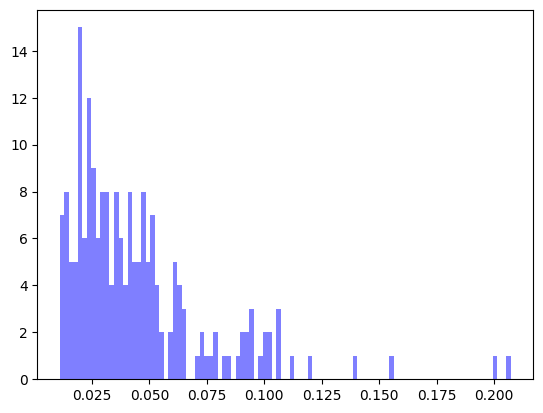

mean: 0.04459210483889708
median: 0.03638718956777584
variance: 0.000963774442994276


In [51]:
n, bins, patches = plt.hist(kabsch_distances, 100, facecolor='blue', alpha=0.5)
plt.show()

print('mean: ' + str(np.mean(kabsch_distances)))
print('median: ' + str(np.median(kabsch_distances)))
print('variance: ' + str(np.var(kabsch_distances)))